# Analysis of historical weather in Ireland

## Author: Joanna Mnich

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import linregress
import numpy as np
from datetime import datetime, timedelta


## Clean and read data

In [ ]:
def clean_station(file_path, output_path):
    # Clean a Met Éireann station CSV and save year, month, wdsp (mean wind speed).
    # Args: file_path (str): path to raw CSV
        # output_path (str): path to save cleaned CSV
    
# Detect first row with actual numeric data (starts with a year)
    data_row = None
    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            # skip empty lines, look for line starting with a digit (year)
            if line.strip() and line.strip()[0].isdigit():
                data_row = i
                break

    if data_row is None:
        print(f"No data found in {file_path}")
        return

# Read CSV from detected data row
    df = pd.read_csv(
        file_path,
        skiprows=data_row,
        header=None,
        na_values=["---", "NaN"],
        on_bad_lines="skip"
    )

# Assign proper column names (based on Met Éireann standard)
    col_names = [
        "year","month","meant","maxtp","mintp","mnmax",
        "mnmin","rain","gmin","wdsp","maxgt","sun"
    ][:df.shape[1]]  # adjust if file has fewer columns
    df.columns = col_names
    
# Keep only relevant columns
    df = df[["year", "month", "wdsp"]]

# Convert to numeric (coerce errors)
    for col in ["year", "month", "wdsp"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Filter years 2005–2025 and remove missing wdsp
    df = df.dropna(subset=["wdsp"])
    df = df[(df["year"] >= 2005) & (df["year"] <= 2025)]

# Save cleaned CSV
    df.to_csv(output_path, index=False)
    print(f"Saved {output_path} — rows: {len(df)}")


In [111]:
stations = {
    "Malin_Head": "Malin_Head.csv",
    "Roches_Point": "Roches_point.csv",
    "Sherkin_Island": "SherkinIsland.csv",
    "Valentia_Observatory": "Valentia_Observatory.csv",
    "Dublin_Airport": "Dublin_Airport.csv",
    "Mt_Dillon": "Mt_Dillon.csv",
    "Casement_Aerodrome": "Casement_Aerodrome.csv",
    "Belmullet": "Belmullet.csv",
    "Mullingar": "Mullingar.csv",
    "Claremorris": "Claremorris.csv"
}

for station, filename in stations.items():
    clean_station(
        file_path=f"data/raw/{filename}",
        output_path=f"data/processed/{station}_cleaned.csv"
    )


Saved data/processed/Malin_Head_cleaned.csv — rows: 250
Saved data/processed/Roches_Point_cleaned.csv — rows: 249
Saved data/processed/Sherkin_Island_cleaned.csv — rows: 249
Saved data/processed/Valentia_Observatory_cleaned.csv — rows: 249
Saved data/processed/Dublin_Airport_cleaned.csv — rows: 251
Saved data/processed/Mt_Dillon_cleaned.csv — rows: 247
Saved data/processed/Casement_Aerodrome_cleaned.csv — rows: 251
Saved data/processed/Belmullet_cleaned.csv — rows: 246
Saved data/processed/Mullingar_cleaned.csv — rows: 251
Saved data/processed/Claremorris_cleaned.csv — rows: 243


## Analyse mean wind speed from merged station script

In [112]:
# Load merged cleaned data
df = pd.read_csv("data/processed/all_stations_cleaned.csv")

# Safety check (remove any accidental master rows)
df = df[df["station"] != "ALL_STATIONS"]

df.head()

mean_wind_station = (
    df.groupby("station")["wdsp"]
      .mean()
      .sort_values(ascending=False)
)

mean_wind_station


station
Malin_Head              14.628400
Sherkin_Island          12.345783
Roches_Point            12.118072
Belmullet               11.711382
Dublin_Airport          10.206375
Casement_Aerodrome       9.704382
Valentia_Observatory     9.306426
Claremorris              7.949383
Mt_Dillon                7.008097
Mullingar                6.158566
Name: wdsp, dtype: float64

In [113]:
# Wind speed range statistics by station
wind_range_station = df.groupby("station")["wdsp"].agg(["mean", "min", "max", "std"])
wind_range_station.sort_values("mean", ascending=False)


,mean,min,max,std
station,,,,
Malin_Head,14.628400,7.8,22.3,2.896937
Sherkin_Island,12.345783,7.8,21.5,2.568464
Roches_Point,12.118072,8.0,19.2,2.062148
Belmullet,11.711382,6.4,18.9,2.224766
Dublin_Airport,10.206375,6.5,16.3,1.892923
Casement_Aerodrome,9.704382,5.7,16.3,2.093481
Valentia_Observatory,9.306426,5.3,17.2,2.029391
Claremorris,7.949383,4.8,12.1,1.192933
Mt_Dillon,7.008097,3.9,12.0,1.333624


## Monthly average wind speed plot for each station

In [114]:
for station in stations.keys():
    df = pd.read_csv(f"data/processed/{station}_cleaned.csv")
    monthly_avg = df.groupby("month")["wdsp"].mean()

    plt.figure()
    plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
    plt.title(f"Average Monthly Wind Speed at {station.replace('_', ' ')} (2005-2025)")
    plt.xlabel("Month")
    plt.ylabel("Average Wind Speed (wdsp)")
    plt.xticks(range(1, 13))
    plt.grid()
    plt.savefig(f"data/plots/{station}_monthly_wind_speed.png")
    plt.close()

## Annual wind speed trends 2005-2025

In [ ]:
# Load merged cleaned data
df = pd.read_csv("data/processed/all_stations_cleaned.csv")

# Remove any accidental master rows
df = df[df["station"] != "ALL_STATIONS"]

# Compute annual mean wind speed per station
annual_trend = df.groupby(["station", "year"])["wdsp"].mean().reset_index()
annual_trend.head(100)

,station,year,wdsp
0,Belmullet,2005,11.533333
1,Belmullet,2006,11.608333
2,Belmullet,2007,11.200000
3,Belmullet,2008,11.958333
4,Belmullet,2009,11.766667
...,...,...,...
95,Malin_Head,2016,14.341667
96,Malin_Head,2017,15.100000
97,Malin_Head,2018,14.841667
98,Malin_Head,2019,14.641667


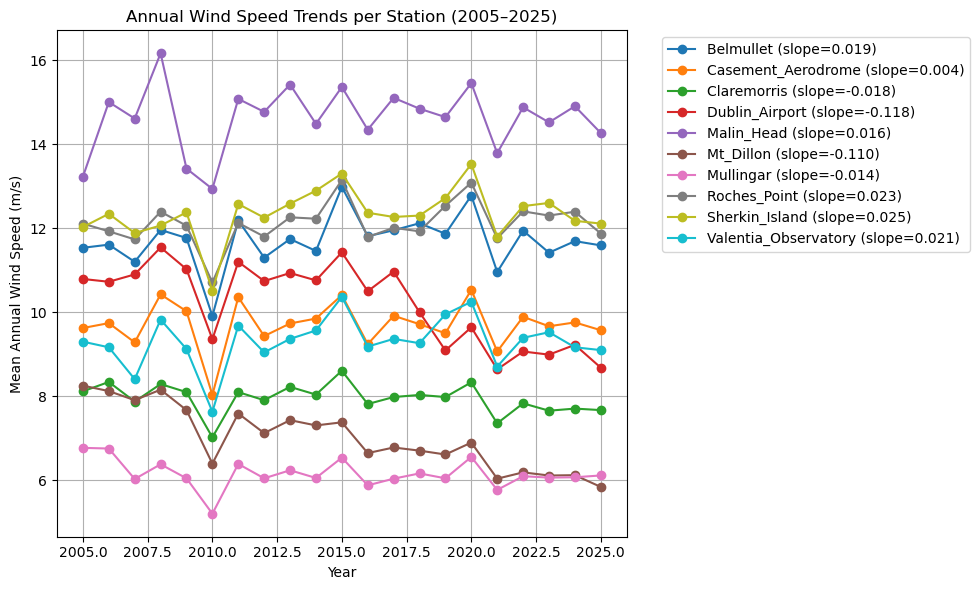

Annual wind speed slopes (m/s per year):
Belmullet: 0.019
Casement_Aerodrome: 0.004
Claremorris: -0.018
Dublin_Airport: -0.118
Malin_Head: 0.016
Mt_Dillon: -0.110
Mullingar: -0.014
Roches_Point: 0.023
Sherkin_Island: 0.025
Valentia_Observatory: 0.021


In [116]:
# Plot annual wind speed trends per station with slopes
plt.figure(figsize=(10,6))
# Dictionary to store slope for each station
slopes = {}

for station in annual_trend["station"].unique():
    subset = annual_trend[annual_trend["station"] == station]
    
    # Linear regression: slope, intercept, r_value, p_value, std_err
    slope, intercept, r_value, p_value, std_err = linregress(subset["year"], subset["wdsp"])
    slopes[station] = slope
    
    # Plot annual mean wind
    plt.plot(subset["year"], subset["wdsp"], marker='o', label=f"{station} (slope={slope:.3f})")

plt.xlabel("Year")
plt.ylabel("Mean Annual Wind Speed (m/s)")
plt.title("Annual Wind Speed Trends per Station (2005–2025)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print slopes for interpretation
print("Annual wind speed slopes (m/s per year):")
for station, slope in slopes.items():
    print(f"{station}: {slope:.3f}")


## Machine Learning Approach: Linear Regression (Scikit-learn)

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [118]:
annual_trend  # columns: year, wdsp

,station,year,wdsp
0,Belmullet,2005,11.533333
1,Belmullet,2006,11.608333
2,Belmullet,2007,11.200000
3,Belmullet,2008,11.958333
4,Belmullet,2009,11.766667
...,...,...,...
205,Valentia_Observatory,2021,8.708333
206,Valentia_Observatory,2022,9.391667
207,Valentia_Observatory,2023,9.525000
208,Valentia_Observatory,2024,9.166667


In [119]:
annual_trend  # columns: year, wdsp
# Prepare forecast
X = annual_trend[["year"]]
y = annual_trend["wdsp"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")


RMSE: 2.510, R²: -0.081


## Monthly Seasonal Wind Pattern and Variability per Station

In [120]:
# Compute monthly means for each station (seasonal pattern)
monthly_pattern = df.groupby(["station", "month"])["wdsp"].mean().reset_index()

# Compute standard deviation per month to see variability
monthly_std = df.groupby(["station", "month"])["wdsp"].std().reset_index()
monthly_std.rename(columns={"wdsp": "std_wdsp"}, inplace=True)

# Merge mean + std
pattern = monthly_pattern.merge(monthly_std, on=["station", "month"])
pattern.head(12)


,station,month,wdsp,std_wdsp
0,Belmullet,1,13.595238,2.344243
1,Belmullet,2,13.080952,2.571112
2,Belmullet,3,12.090476,1.524764
3,Belmullet,4,10.704762,1.028823
4,Belmullet,5,11.066667,1.892441
5,Belmullet,6,10.480952,1.322354
6,Belmullet,7,9.776190,1.232439
7,Belmullet,8,10.765000,1.497814
8,Belmullet,9,11.075000,1.917750
9,Belmullet,10,12.110000,1.841024


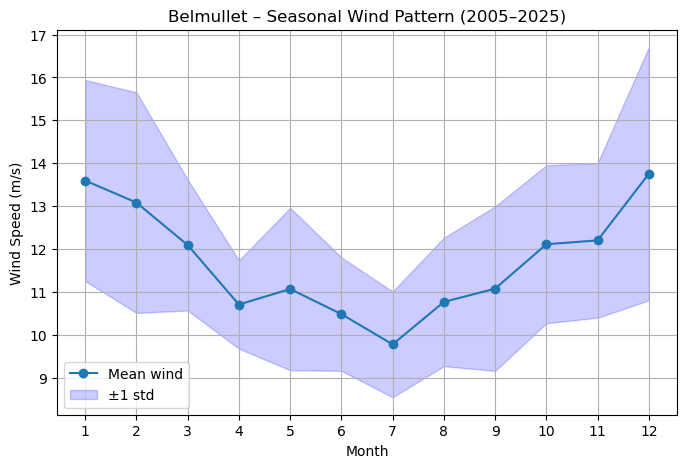

In [121]:
# Visualize seasonal pattern with variability for Belmullet
station_name = "Belmullet"
subset = pattern[pattern["station"] == station_name]

plt.figure(figsize=(8,5))
plt.plot(subset["month"], subset["wdsp"], marker='o', label="Mean wind")
plt.fill_between(subset["month"], 
                 subset["wdsp"] - subset["std_wdsp"], 
                 subset["wdsp"] + subset["std_wdsp"], 
                 color='blue', alpha=0.2, label="±1 std")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Wind Speed (m/s)")
plt.title(f"Belmullet – Seasonal Wind Pattern (2005–2025)")
plt.legend()
plt.grid(True)
plt.show()


## Power output next week (forecast)

#### Estimate next week’s wind power output for 4 stations using  P = ½ × ρ × A × V³ formula.

In [122]:
# Extract station metadata from raw files
files = [
    "data/raw/Dublin_Airport.csv",
    "data/raw/Malin_Head.csv",
    "data/raw/Roches_point.csv",
    "data/raw/Belmullet.csv"
]

dfs = []

for f in files:
    with open(f, "r") as file:
        lines = file.readlines()
    
    #  Station Name
    station_name = lines[0].split(":")[1].strip().title()  
    
    # Station Height (usuń 'M')
    height = float(lines[1].split(":")[1].replace("M","").strip())
    
    # Latitude,Longitude
    lat_str, lon_str = lines[2].split(",")
    latitude = float(lat_str.split(":")[1].strip())
    longitude = float(lon_str.split(":")[1].strip())
    
    # DataFrame created
    df = pd.DataFrame({
        "station": [station_name],
        "latitude": [latitude],
        "longitude": [longitude],
        "height_m": [height]
    })
    
    dfs.append(df)

# Connection all stations in one DataFrame
stations_cleaned = pd.concat(dfs, ignore_index=True)

# Save to file
stations_cleaned.to_csv("data/processed/selected_stations.csv", index=False)
print(stations_cleaned)


          station  latitude  longitude  height_m
0  Dublin Airport    53.428     -6.241      71.0
1      Malin Head    55.372     -7.339      20.0
2    Roches Point    51.793     -8.244      40.0
3       Belmullet    54.228    -10.007       9.0


In [123]:
# Load merged cleaned data
df = pd.read_csv("data/processed/all_stations_cleaned.csv")

# Remove any accidental master rows
df = df[df["station"] != "ALL_STATIONS"]

# Prepare forecast
stations = ["Dublin_Airport", "Malin_Head", "Roches_Point", "Belmullet"]
forecast_days = 7
today = datetime.today()

# Constants for power calculation
ρ = rho = 1.225  # air density in kg/m³
A = 100      # rotor swept area in m² (example)
# P = 0.5 * rho * A * V^3

forecast_list = []

for station in stations:
    subset = df[df["station"] == station]
    
    # Monthly average wind speed for current month
    current_month = today.month
    monthly_avg = subset[subset["month"] == current_month]["wdsp"].mean()
    
    for i in range(forecast_days):
        date = today + timedelta(days=i)
        # Add small random variability ±1 m/s
        wind_speed = monthly_avg + np.random.uniform(-1,1)
        
        # Estimated power output using P = 0.5 * rho * A * V^3
        power_output = 0.5 * rho * A * wind_speed**3
        
        forecast_list.append({
            "station": station,
            "date": date.date(),
            "wdsp(m/s)": round(wind_speed, 2),
            "estimated_power_W": round(power_output, 2)
        })

# Create DataFrame from forecast list
forecast_df = pd.DataFrame(forecast_list)

# Display result
print(forecast_df)



           station        date  wdsp(m/s)  estimated_power_W
0   Dublin_Airport  2026-01-07      11.08           83385.58
1   Dublin_Airport  2026-01-08      11.16           85222.28
2   Dublin_Airport  2026-01-09      12.71          125689.12
3   Dublin_Airport  2026-01-10      12.46          118487.76
4   Dublin_Airport  2026-01-11      12.71          125640.93
5   Dublin_Airport  2026-01-12      10.82           77620.93
6   Dublin_Airport  2026-01-13      11.73           98800.16
7       Malin_Head  2026-01-07      16.97          299535.60
8       Malin_Head  2026-01-08      17.98          355946.32
9       Malin_Head  2026-01-09      18.28          374360.41
10      Malin_Head  2026-01-10      16.64          282332.64
11      Malin_Head  2026-01-11      17.43          324563.91
12      Malin_Head  2026-01-12      18.25          372591.27
13      Malin_Head  2026-01-13      17.76          343337.20
14    Roches_Point  2026-01-07      14.18          174752.86
15    Roches_Point  2026

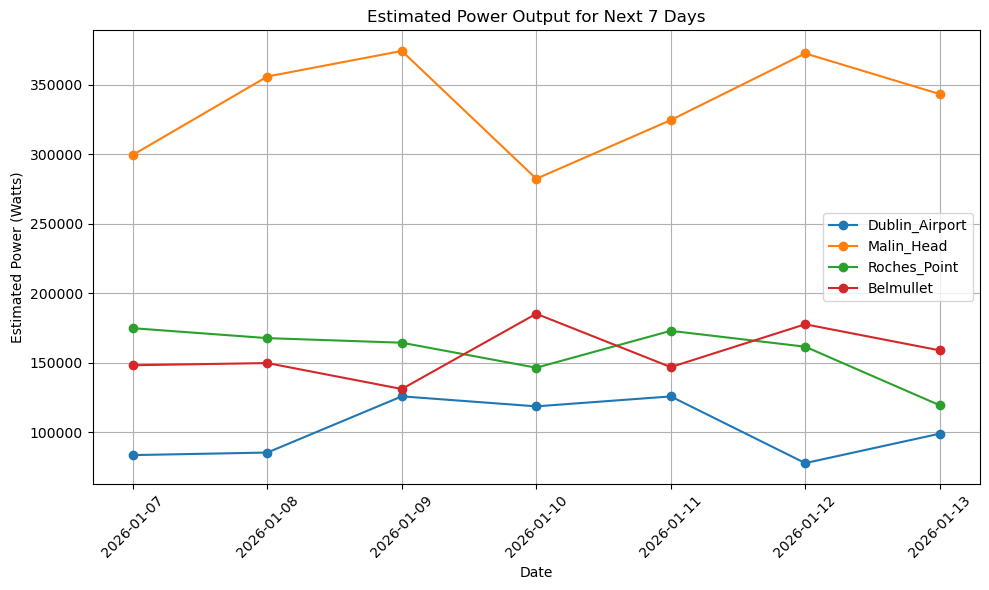

In [124]:
# Plot
plt.figure(figsize=(10,6))
for station in stations:
    subset = forecast_df[forecast_df["station"] == station]
    plt.plot(subset["date"], subset["estimated_power_W"], marker='o', label=station)

plt.title("Estimated Power Output for Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Estimated Power (Watts)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

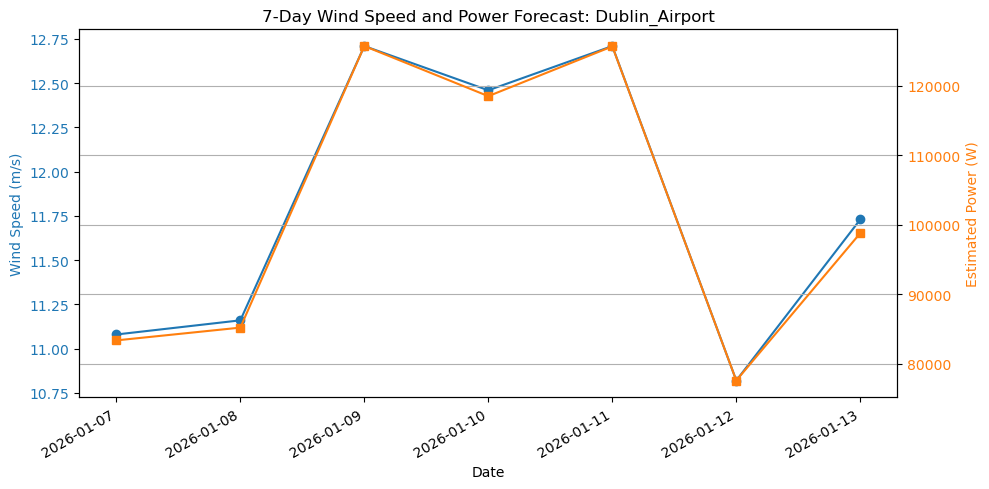

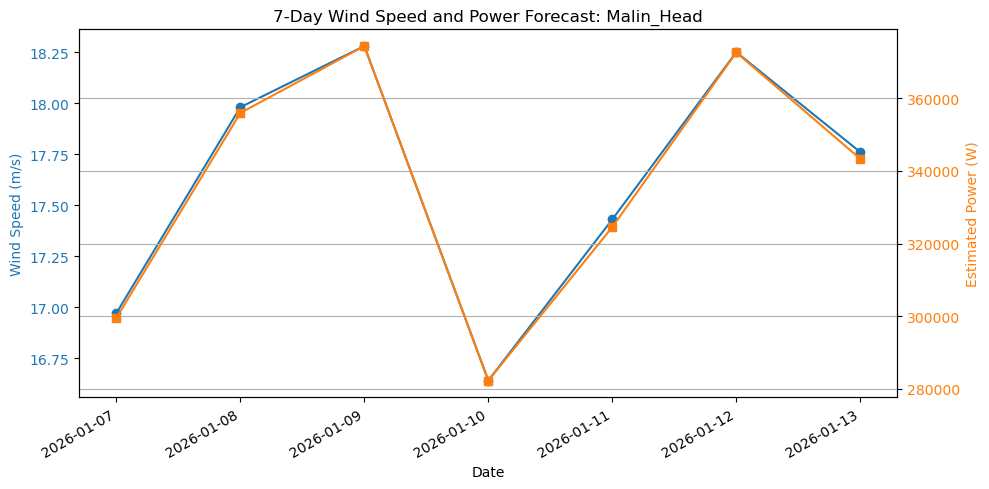

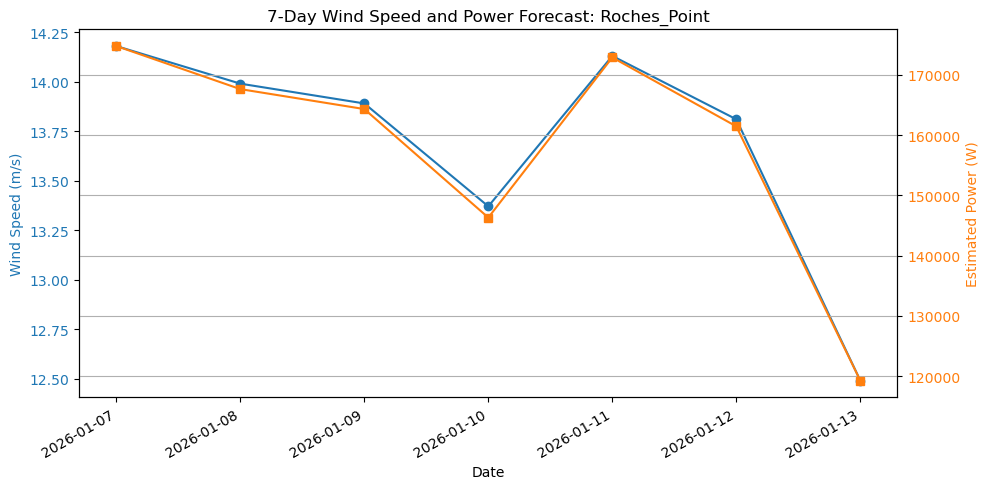

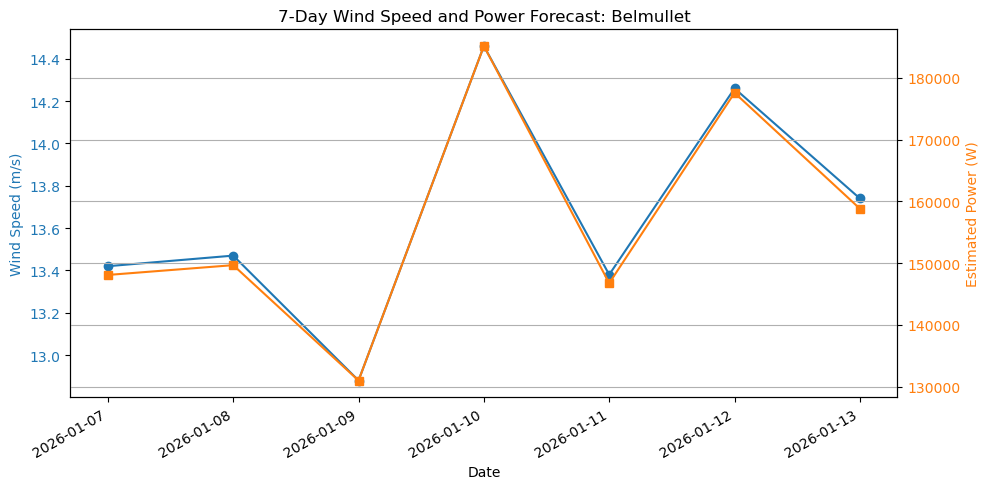

In [125]:
# Detailed plot with wind speed and power
stations = forecast_df['station'].unique()

for station in stations:
    subset = forecast_df[forecast_df['station'] == station]

    fig, ax1 = plt.subplots(figsize=(10,5))

    # Wind speed axis (LEFT)
    ax1.plot(
        subset['date'],
        subset['wdsp(m/s)'],
        marker='o',
        color='tab:blue',
        label='Wind Speed (m/s)'
    )
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Wind Speed (m/s)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Power axis (RIGHT)
    ax2 = ax1.twinx()
    ax2.plot(
        subset['date'],
        subset['estimated_power_W'],
        marker='s',
        color='tab:orange',
        label='Estimated Power (W)'
    )
    ax2.set_ylabel("Estimated Power (W)", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title(f"7-Day Wind Speed and Power Forecast: {station}")
    fig.autofmt_xdate()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Trend Analysis for a wind speeds in the next 10 years

In [142]:
# Forecast configuration

FORECAST_START = 2026
FORECAST_END = 2035

forecast_years = list(range(FORECAST_START, FORECAST_END + 1))
forecast_results = []

# Annual wind speed forecast

for station in annual_trend["station"].unique():
    
    # Select data for one station
    df_station = annual_trend[annual_trend["station"] == station]
    
    # Features and target
    X = df_station[["year"]]
    y = df_station["wdsp"]
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Prepare future years DataFrame
    future_years_df = pd.DataFrame(forecast_years, columns=["year"])
    
    # Predict future wind speed
    predicted_wdsp = model.predict(future_years_df)
    
    # Store results
    for year, wind in zip(forecast_years, predicted_wdsp):
        forecast_results.append({
            "station": station,
            "year": year,
            "predicted_wind_speed": round(wind, 2)
        })

# Convert results to DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Save to file
forecast_df.to_csv(
    "forecast_wind_speed_2026_2035.csv",
    index=False
)
forecast_df.head()

,station,year,predicted_wind_speed
0,Belmullet,2026,11.91
1,Belmullet,2027,11.93
2,Belmullet,2028,11.95
3,Belmullet,2029,11.96
4,Belmullet,2030,11.98
